In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import optuna
from scipy.signal import medfilt, savgol_filter
import umap 
import random
from tslearn.metrics import dtw, dtw_path

reducer = umap.UMAP()

seed=random.seed(314)

DATAPATH = "csv/"
CSV_STRING = "ep{i}.csv"

# Dataframe Building

In [2]:
def detect_grasp_phase(states, timestamps,
                       joint_indices=("joint_6", "joint_12"),  # 0-based: 6 and 12
                       zero_thresh=3.4,        # threshold to call "near zero"
                       motion_thresh=5.0,      # threshold for "movement" before/after
                       min_duration_s=1):   # optional: min grasp duration in seconds
    """
    states: dict with keys 'timestamps' and 'joint_x' for x = 1, ..., 12
    returns: dict with keys 'grasp_idx'=(start_idx,end_idx),
             'pre_idx' = (0,start-1), 'post_idx'=(end+1, T-1)
             if no valid grasp found, returns None
    """
    j1, j2 = joint_indices
    t = states.shape[0]

    # boolean mask where both are "near zero"
    mask = (np.abs(states[j1]) <= zero_thresh) & (np.abs(states[j2]) <= zero_thresh)

    # find contiguous True segments
    segments = []
    in_seg = False
    for i, val in enumerate(mask):
        if val and not in_seg:
            seg_start = i
            in_seg = True
        elif (not val) and in_seg:
            seg_end = i - 1
            segments.append((seg_start, seg_end))
            in_seg = False
    if in_seg:
        segments.append((seg_start, t-1))

    if not segments:
        return None

    # compute durations and filter by min_duration_s
    segs_valid = []
    for (s,e) in segments:
        dur = timestamps[e] - timestamps[s]
        if dur >= min_duration_s:
            segs_valid.append((s,e,dur))

    if not segs_valid:
        segs_valid = [(s,e,(timestamps[e]-timestamps[s])) for (s,e) in segments]  # fallback

    # pick the longest valid segment
    s,e,dur = max(segs_valid, key=lambda x: x[2])

    # ensure pre and post have motion above motion_thresh
    # check before s: any index i < s where either joint abs > motion_thresh
    has_motion_before = np.any((np.abs(states[j1][:s]) >= motion_thresh) | (np.abs(states[j2][:s]) >= motion_thresh)) if s>0 else False
    has_motion_after  = np.any((np.abs(states[j1][e+1:]) >= motion_thresh) | (np.abs(states[j2][e+1:]) >= motion_thresh)) if e < t-1 else False

    if not (has_motion_before and has_motion_after):
        # try other segments in decreasing duration order to find one that satisfies the condition
        segs_sorted = sorted(segs_valid, key=lambda x: -x[2])
        found = False
        for (s2,e2,dur2) in segs_sorted:
            has_motion_before = np.any((np.abs(states[j1][:s2]) >= motion_thresh) | (np.abs(states[j2][:s2]) >= motion_thresh)) if s2>0 else False
            has_motion_after  = np.any((np.abs(states[j1][e2+1:]) >= motion_thresh) | (np.abs(states[j2][e2+1:]) >= motion_thresh)) if e2 < t-1 else False
            if has_motion_before and has_motion_after:
                s,e = s2,e2
                found = True
                break
        if not found:
            # fallback: choose the longest segment anyway
            pass

    return {"pre_grasp": (0, max(0,int(s)-1)),
            "grasp": (int(s), int(e)),
            "post_grasp": (min(t-1,int(e)+1), t-1)}

def phases_to_arrayses(phase, num_timesteps):
    phase_arr = np.empty(num_timesteps, dtype=object)

    for name, (s, e) in phase.items():
        phase_arr[s:e+1] = name

    return phase_arr

def median_filter_episode(states, kernel_size=5):
    return {
        joint: medfilt(series, kernel_size=kernel_size)
        for joint, series in states.items()
    }

def savgol_episode(states, window=9, poly=2):
    return {
        joint: savgol_filter(series, window_length=window, polyorder=poly)
        for joint, series in states.items()
    }

def trim_outliers(x, z=3.0):
    mu, sigma = np.mean(x), np.std(x)
    return np.clip(x, mu - z*sigma, mu + z*sigma)

In [3]:
def create_df():
    _, _, files = next(os.walk(DATAPATH))
    num_files = len(files)

    # print(num_files)

    rows = []
    for i in range(num_files):
        f = pd.read_csv(DATAPATH + CSV_STRING.format(i=i))

        # Colect states and timestamps
        states = f.drop(columns=["timestamp"])
        states = pd.DataFrame.from_dict(median_filter_episode(states))
        states = pd.DataFrame.from_dict(savgol_episode(states))
        # states = trim_outliers(states)
        timestamps = f["timestamp"]

        # Calculate pre-grasp, grasp and post-grasp phases
        phases = detect_grasp_phase(states, timestamps)
        phase_array = phases_to_arrayses(phases, len(timestamps))

        if phases is None:
            print("FAILED TO SPLIT PHASES!!! EPISODE", i)

        row = {
            "episode_id": i,
            "n_steps": f.shape[0],
            "duration": float(timestamps[f.shape[0]-1] - timestamps[0]),
            "states": states,
            "timestamps": timestamps,
            "phase": phase_array
        }
        rows.append(row)

    episodes_df = pd.DataFrame(rows)

    # get entry episodes_df.loc[1, "states"]["joint_1"][0]
    return episodes_df


In [4]:
episodes_df = create_df()
#print(episodes_df[label][episode_number]["joint_x"][timestep])

# print(np.asarray(episodes_df["states"][0]["joint_6"]))
create_df()

episode_id  n_steps   duration  \
0             0      388  12.900000   
1             1      232   7.700000   
2             2      246   8.166667   
3             3      222   7.366667   
4             4      188   6.233333   
..          ...      ...        ...   
225         225      341  11.333333   
226         226      247   8.200000   
227         227      261   8.666667   
228         228      338  11.233334   
229         229      257   8.533334   

                                                states  \
0          joint_1    joint_2    joint_3    joint_4...   
1          joint_1    joint_2    joint_3    joint_4...   
2           joint_1    joint_2    joint_3    joint_...   
3           joint_1    joint_2    joint_3    joint_...   
4           joint_1    joint_2    joint_3    joint_...   
..                                                 ...   
225         joint_1    joint_2    joint_3    joint_...   
226        joint_1    joint_2    joint_3    joint_4...   
227         joint_1    joint_2    joint_3    joint_...   
228        joint_1    joint_2    joint_3    joint_4...   
229         joint_1    joint_2    joint_3    joint_...   

                                            timestamps  \
0    0       0.000000
1       0.033333
2       0.06...   
1    0      0.000000
1      0.033333
2      0.06666...   
2    0      0.000000
1      0.033333
2      0.06666...   
3    0      0.000000
1      0.033333
2      0.06666...   
4    0      0.000000
1      0.033333
2      0.06666...   
..                                                 ...   
225  0       0.000000
1       0.033333
2       0.06...   
226  0      0.000000
1      0.033333
2      0.06666...   
227  0      0.000000
1      0.033333
2      0.06666...   
228  0       0.000000
1       0.033333
2       0.06...   
229  0      0.000000
1      0.033333
2      0.06666...   

                                                 phase  
0    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  
1    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  
2    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  
3    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  
4    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  
..                                                 ...  
225  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  
226  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  
227  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  
228  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  
229  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...  

[230 rows x 6 columns]

In [5]:
episodes_df["valid"] = True

# mark bad episodes
episodes_df.loc[episodes_df["episode_id"] == 145, "valid"] = False
episodes_df.loc[episodes_df["episode_id"] == 8, "valid"] = False


# Joint by joint work

## DTW work and Visualisation

In [6]:
def episode_df_to_long(df):
    rows = []

    for _, row in df.iterrows():
        episode_id = row["episode_id"]
        states = row["states"]
        timestamps = row["timestamps"]
        phase = row["phase"]
        valid = row["valid"]

        n_steps = len(timestamps)

        for t in range(n_steps):
            time = timestamps[t]

            for j in range(12):
                rows.append({
                    "episode_id": episode_id,
                    "time": time,
                    "timestep": t,
                    "joint": j+1,
                    "position": states[f"joint_{j+1}"][t],
                    "phase": phase[t],
                    "valid": valid
                })

    return pd.DataFrame(rows)

Joint 1 and 7 = shoudler turn
Joint 2 and 8 = shoudler lift
Joint 3 and 9 = elbow lift
Joint 4 and 10 = wrist lift
Joint 5 and 11 = wrist roll
Joint 6 and 12 = pinch


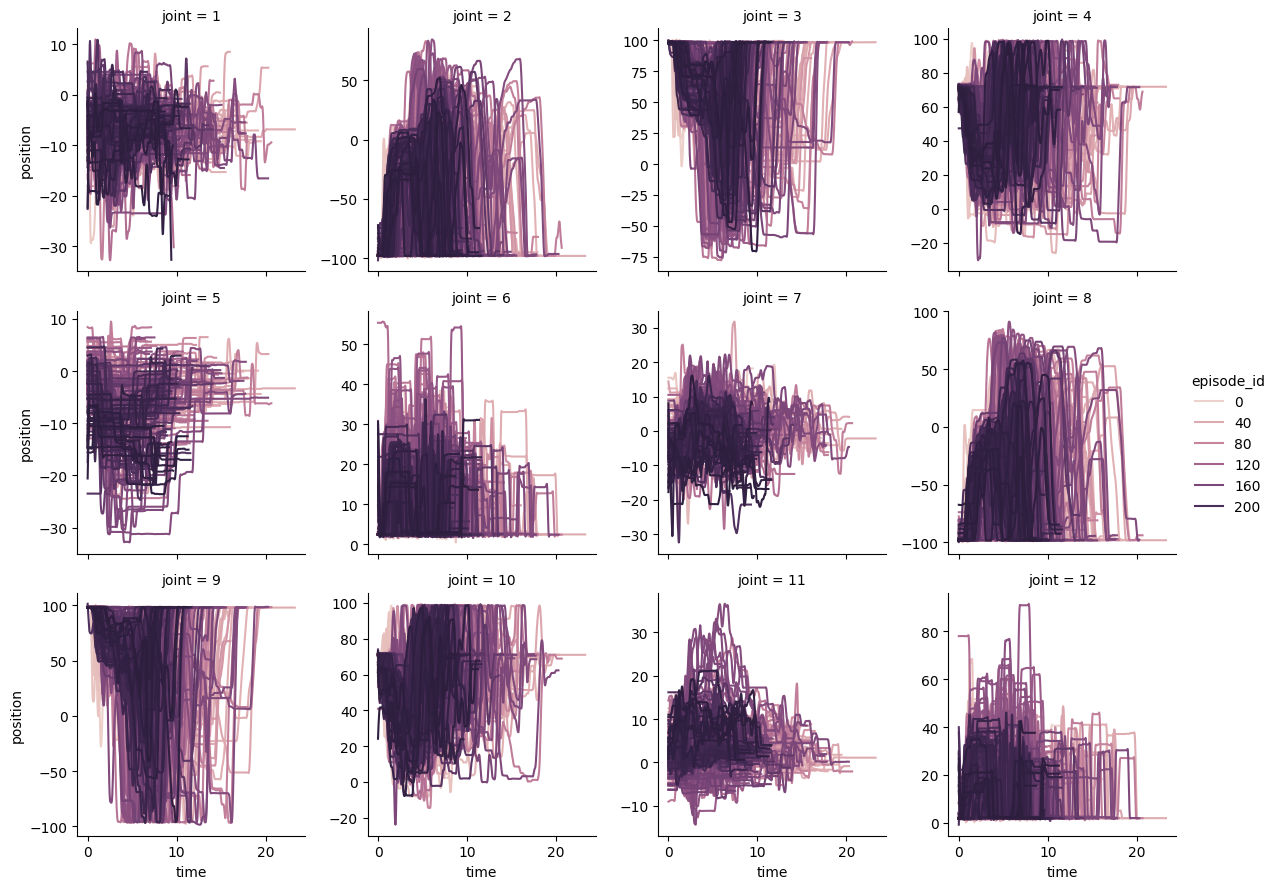

In [7]:
# clustering_df = process_data_for_clustering(episodes_df)
df_by_timestep_by_joint = episode_df_to_long(episodes_df)

print("Joint 1 and 7 = shoudler turn")
print("Joint 2 and 8 = shoudler lift")
print("Joint 3 and 9 = elbow lift")
print("Joint 4 and 10 = wrist lift")
print("Joint 5 and 11 = wrist roll")
print("Joint 6 and 12 = pinch")
sns.relplot(
    data=df_by_timestep_by_joint[df_by_timestep_by_joint["valid"]],
    x="time",
    y="position",
    hue="episode_id",
    col="joint",
    kind="line",
    col_wrap=4,
    height=3,
    facet_kws={"sharey": False}
)

# sns.relplot(
#     data=df_by_timestep_by_joint,
#     x="time",
#     y="position",
#     hue="episode_id",
#     col="joint",
#     row="phase",          # ⬅ phase separation
#     kind="line",
#     height=2.5,
#     aspect=1.2,
#     facet_kws={"sharey": False, "sharex": False}
# )


## Phase splits

Can incorporate the phase building into original dataframe builder to make df_to_long easier

In [8]:
df_by_timestep_by_joint = episode_df_to_long(episodes_df)

In [9]:
def dtw_align_sequences(sequences):
    """
    sequences: list of 1D numpy arrays
    returns: list of aligned arrays (same length as reference)
    """
    ref = sequences[0]
    aligned = []

    for seq in sequences:
        path, _ = dtw_path(ref, seq)
        # map seq onto ref index
        warped = np.zeros(len(ref))
        counts = np.zeros(len(ref))

        for i_ref, i_seq in path:
            warped[i_ref] += seq[i_seq]
            counts[i_ref] += 1

        warped /= np.maximum(counts, 1)
        aligned.append(warped)

    return np.array(aligned)

In [10]:
def build_dtw_aligned_df(df, phase_name, joint_id):
    sub = df[(df["phase"] == phase_name) & (df["joint"] == joint_id)]
    assert type(sub) == pd.DataFrame

    sequences = []
    episode_ids = []

    for ep, g in sub.groupby("episode_id"):
        seq = g.sort_values("time")["position"].values
        if len(seq) > 10:   # avoid degenerate sequences
            sequences.append(seq)
            episode_ids.append(ep)

        else:
            print(ep, "BAD EP")

    aligned = dtw_align_sequences(sequences)

    rows = []
    for ep_id, seq in zip(episode_ids, aligned):
        for t, val in enumerate(seq):
            rows.append({
                "episode_id": ep_id,
                "aligned_time": t,
                "position": val,
                "phase": phase_name,
                "joint": joint_id
            })

    return pd.DataFrame(rows), sequences

3
228
189


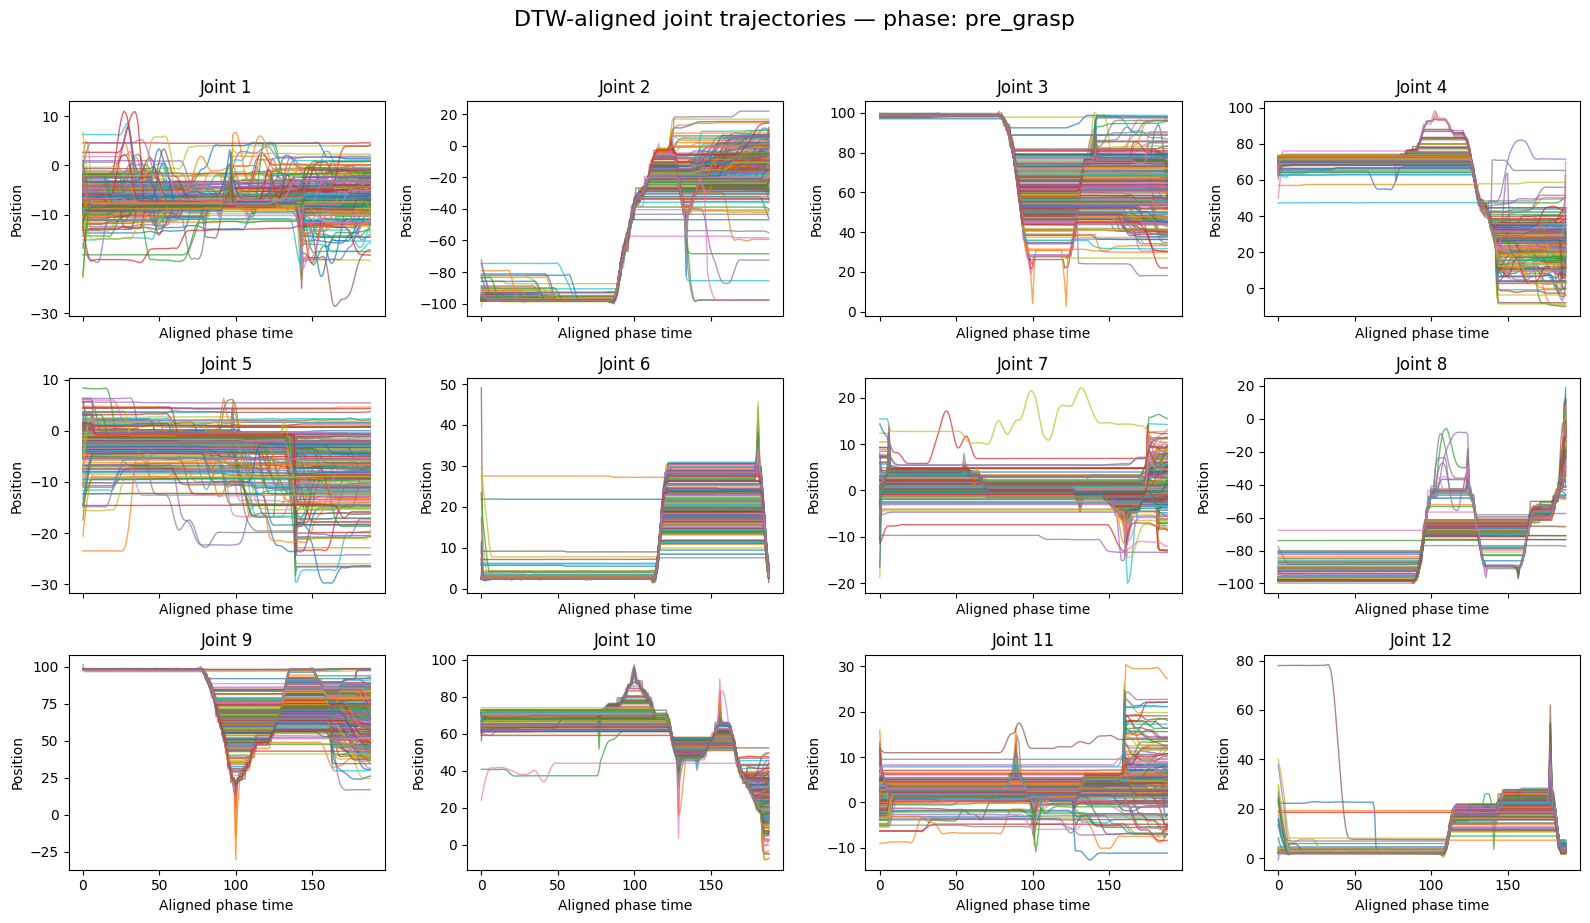

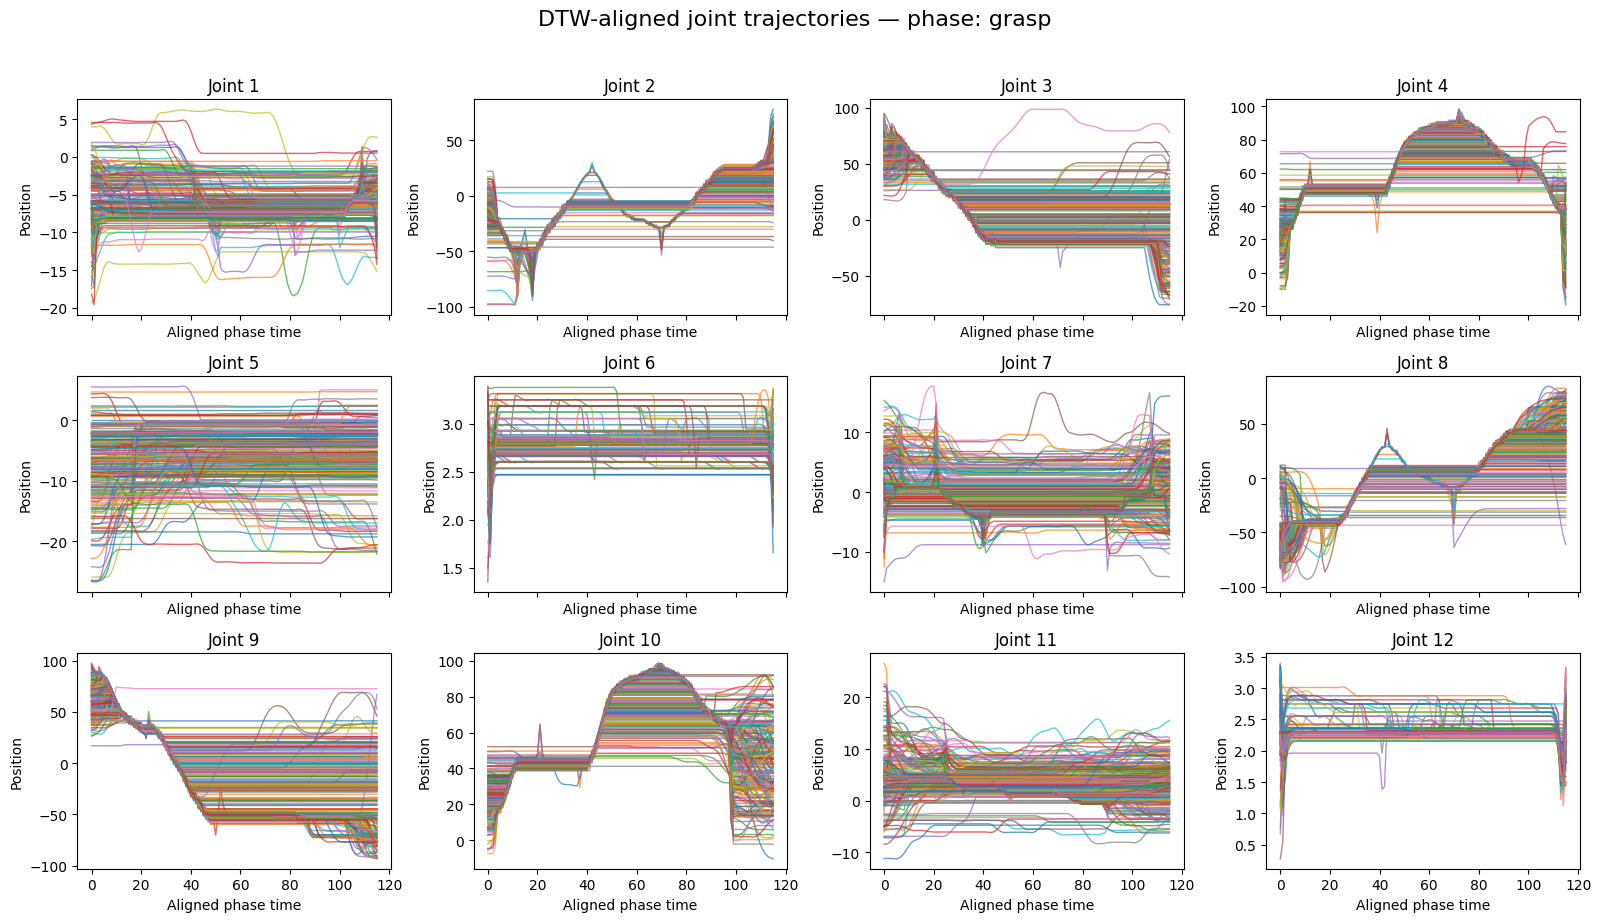

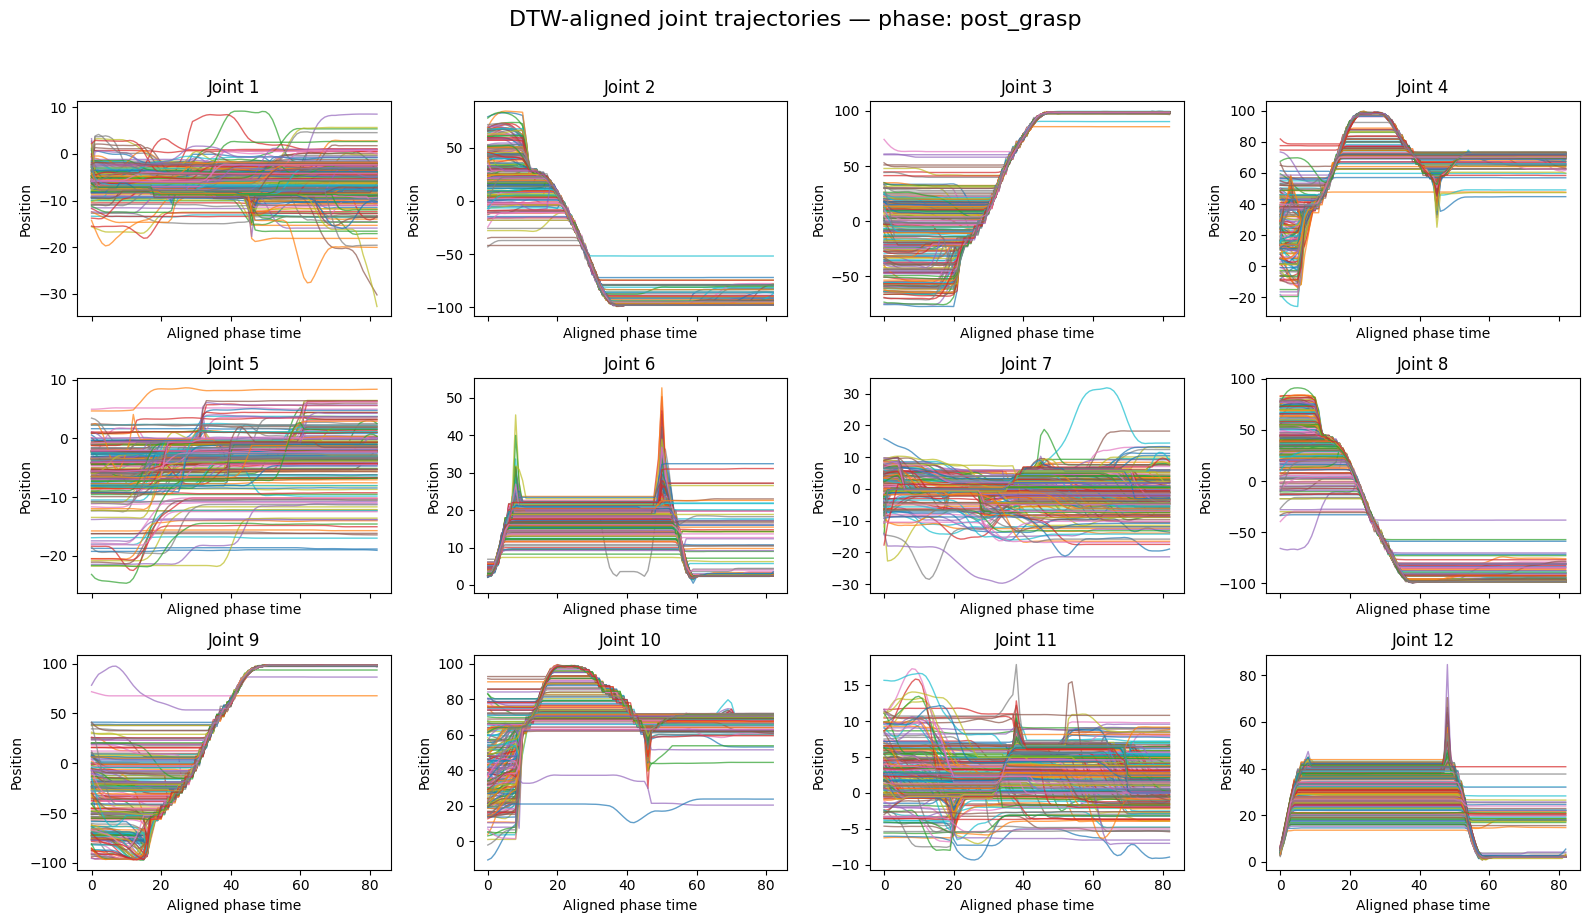

In [11]:
aligned_dfs = []
phases = ["pre_grasp", "grasp", "post_grasp"]

sequences = [] # ["pre_grasp", "grasp", "post_grasp"][] (3, seq length of episode)

for phase in phases:
    for joint in range(1, 13):

        aligned_df, seqs = build_dtw_aligned_df(
            df_by_timestep_by_joint[df_by_timestep_by_joint["valid"]],
            phase_name=phase,
            joint_id=joint
        )
        
        aligned_dfs.append(aligned_df)
    sequences.append(seqs) # seqs is (episode length, )

print(len(sequences))
print(len(sequences[0]))
print(len(sequences[0][0]))
    

dtw_df = pd.concat(aligned_dfs, ignore_index=True)
joints = sorted(dtw_df["joint"].unique())

# sns.relplot(
#     data=dtw_df,
#     x="aligned_time",
#     y="position",
#     hue="episode_id",
#     col="joint",
#     row="phase",
#     kind="line",
#     height=2.5,
#     aspect=1.2,
#     facet_kws={"sharey": False},
#     legend=False
# )

for phase in phases:
    phase_df = dtw_df[dtw_df["phase"] == phase]

    n_cols = 4
    n_rows = int(np.ceil(len(joints) / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 3 * n_rows),
        sharex=True,
        sharey=False
    )

    axes = axes.flatten()

    for ax, joint in zip(axes, joints):
        joint_df = phase_df[phase_df["joint"] == joint]

        for ep_id, g in joint_df.groupby("episode_id"):
            g = g.sort_values("aligned_time")
            ax.plot(
                g["aligned_time"],
                g["position"],
                alpha=0.7,
                linewidth=1
            )

        ax.set_title(f"Joint {joint}")
        ax.set_xlabel("Aligned phase time")
        ax.set_ylabel("Position")


    # Turn off unused axes
    for ax in axes[len(joints):]:
        ax.axis("off")

    fig.suptitle(
        f"DTW-aligned joint trajectories — phase: {phase}",
        fontsize=16,
        y=1.02
    )

    plt.tight_layout()
    plt.show()


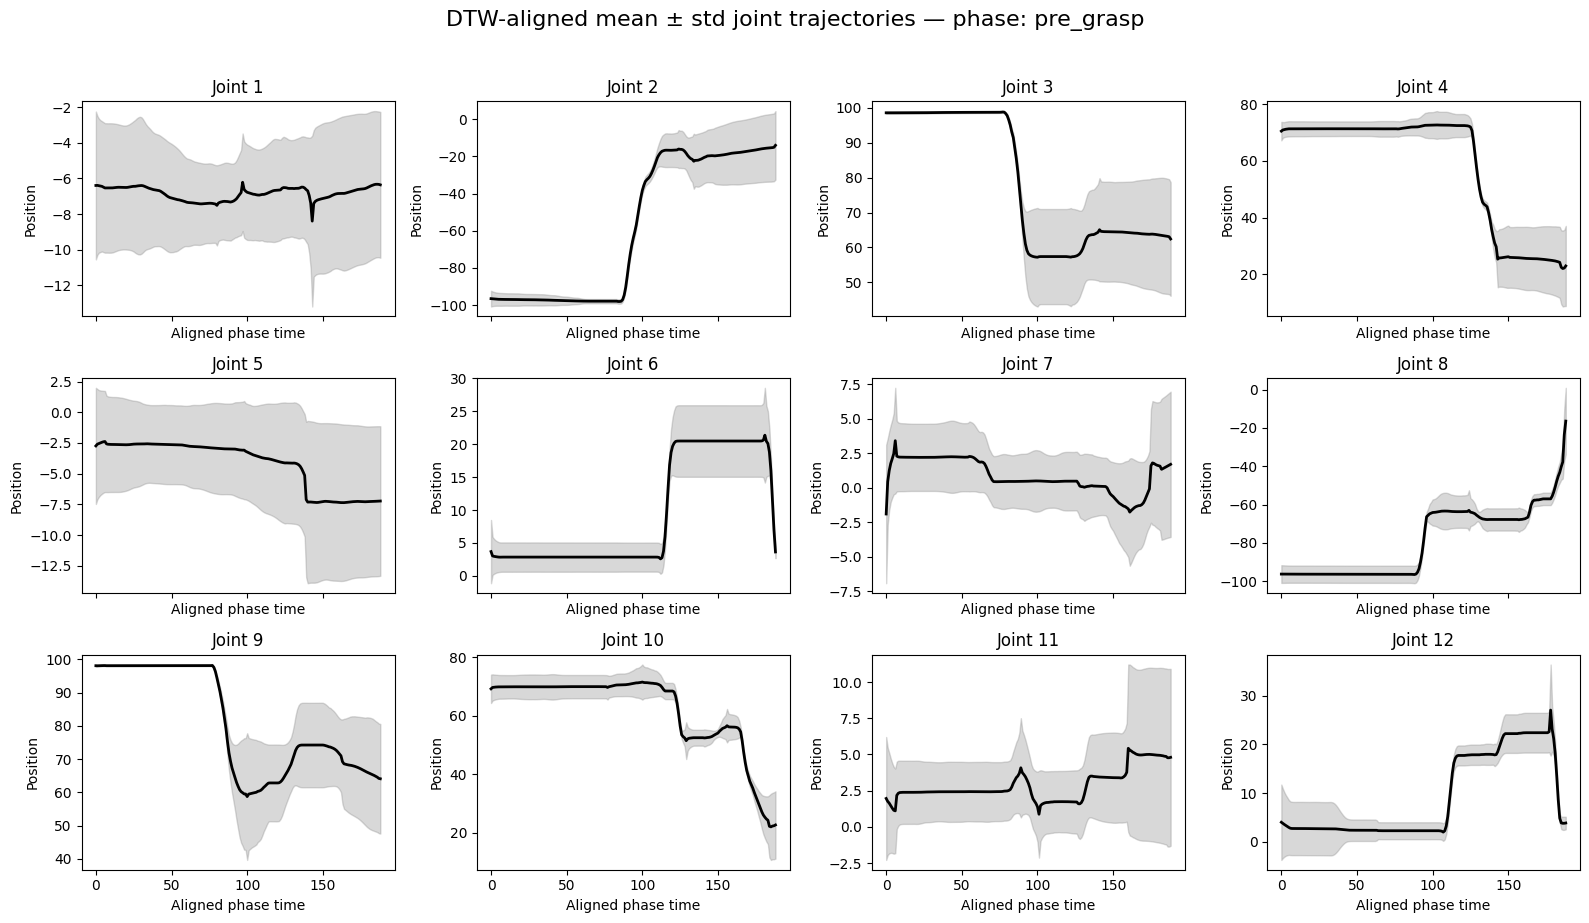

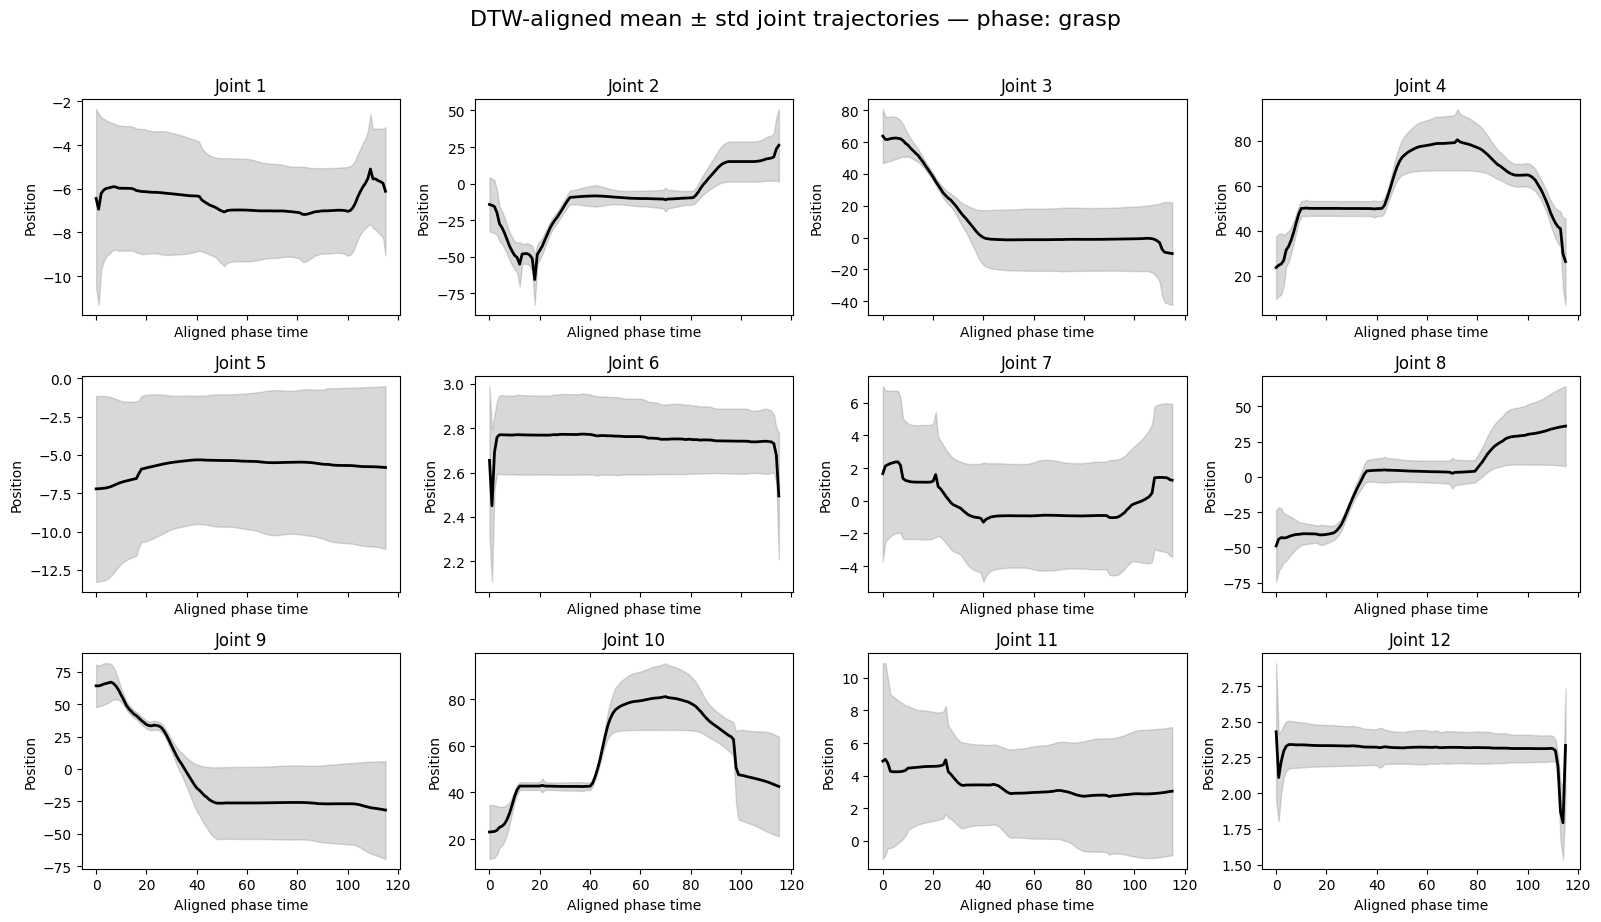

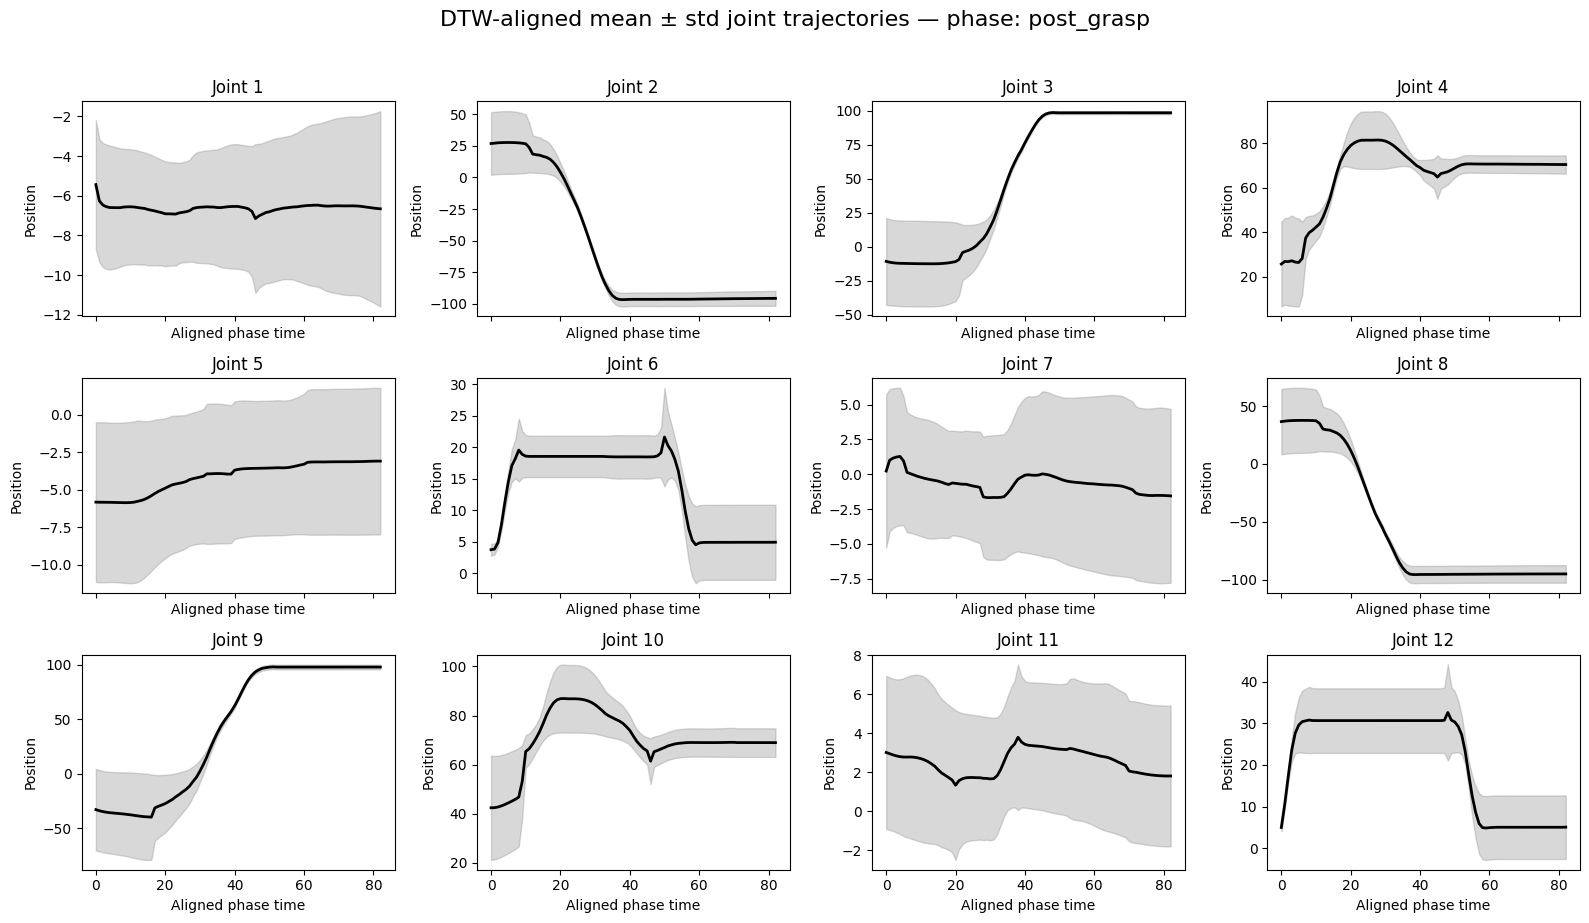

In [12]:
for phase in phases:
    phase_df = dtw_df[dtw_df["phase"] == phase]

    n_cols = 4
    n_rows = int(np.ceil(len(joints) / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 3 * n_rows),
        sharex=True,
        sharey=False
    )

    axes = axes.flatten()

    for ax, joint in zip(axes, joints):
        joint_df = phase_df[phase_df["joint"] == joint]

        # group by aligned_time to compute mean & std
        stats = (
            joint_df
            .groupby("aligned_time")["position"]
            .agg(["mean", "std"])
            .reset_index()
        )

        ax.plot(
            stats["aligned_time"],
            stats["mean"],
            color="black",
            linewidth=2,
            label="mean"
        )

        ax.fill_between(
            stats["aligned_time"],
            stats["mean"] - stats["std"],
            stats["mean"] + stats["std"],
            alpha=0.3,
            color="gray",
            label="±1 std"
        )

        ax.set_title(f"Joint {joint}")
        ax.set_xlabel("Aligned phase time")
        ax.set_ylabel("Position")

    # turn off unused axes
    for ax in axes[len(joints):]:
        ax.axis("off")

    fig.suptitle(
        f"DTW-aligned mean ± std joint trajectories — phase: {phase}",
        fontsize=16,
        y=1.02
    )

    plt.tight_layout()
    plt.show()

## Clustering phases

Episode-level clustering using DTW distances. Do summed distance across phases with weighting on phases. Could weight joints?

In [13]:
def dtw_distance_matrix(sequences):
    """
    sequences: list of 1D numpy arrays
    returns: NxN symmetric DTW distance matrix
    """
    N = len(sequences)
    D = np.zeros((N, N))

    for i in range(N):
        for j in range(i + 1, N):
            d = dtw(sequences[i], sequences[j])
            D[i, j] = d
            D[j, i] = d

    return D

In [14]:
D_pre = dtw_distance_matrix(sequences[0])
D_grasp = dtw_distance_matrix(sequences[1])
D_post = dtw_distance_matrix(sequences[2])

In [15]:
def weighted_episode_dtw_distance(
    episodes_df,
    phase_weights,
    joint_weights,
    min_len=5
):
    """
    Returns:
        D : (N, N) symmetric distance matrix
    """
    N = len(episodes_df)
    D = np.zeros((N, N), dtype=float)

    # infer phase names robustly (union across episodes)
    all_phases = list(set(episodes_df.iloc[0]["phase"]))
    joint_names = list(episodes_df.iloc[0]["states"].keys())

    for i in range(N):
        row_i = episodes_df.iloc[i]
        phases_i = row_i["phase"]
        states_i = row_i["states"]

        for j in range(i + 1, N):
            row_j = episodes_df.iloc[j]
            phases_j = row_j["phase"]
            states_j = row_j["states"]

            dist_ij = 0.0

            for phase_name in all_phases:
                w_phase = phase_weights.get(phase_name, 1.0)

                mask_i = phases_i == phase_name
                mask_j = phases_j == phase_name

                if mask_i.sum() < min_len or mask_j.sum() < min_len:
                    continue

                for joint in joint_names:
                    w_joint = joint_weights.get(joint, 1.0)

                    seq_i = states_i[joint][mask_i]
                    seq_j = states_j[joint][mask_j]

                    d = dtw(seq_i, seq_j)
                    d = d / max(len(seq_i), len(seq_j))
                    dist_ij += w_phase * w_joint * d

            D[i, j] = dist_ij
            D[j, i] = dist_ij

    return D

### Hyper-parameter tuning

In [ ]:
def objective(trial):
    # suggest weights

    cluster = trial.suggest_int("cluster", 2, 6)

    phase_weights_raw = np.array([
        trial.suggest_float(f"phase_{p}", 0.1, 5.0)
        for p in phases
    ])

    joint_weights_raw = np.array([
        trial.suggest_float(f"joint_{j}", 0.1, 5.0)
        for j in range(6) # Half number of joints as motors should have same weights for corresponding joints
    ])

    joint_weights_raw = np.append(joint_weights_raw, joint_weights_raw)

    phase_weights_raw /= phase_weights_raw.sum()
    joint_weights_raw /= joint_weights_raw.sum()


    phase_weights = {
        p: float(w) for p, w in zip(phases, phase_weights_raw)
    }

    joint_weights = {
        j: float(w) for j, w in zip(joints, joint_weights_raw)
    }

    # compute distance matrix
    D = weighted_episode_dtw_distance(
        episodes_df,
        phase_weights,
        joint_weights
    )

    # cluster
    clustering = AgglomerativeClustering(
        n_clusters=cluster,
        metric="precomputed",
        linkage="average"
    ).fit(D)

    labels = clustering.labels_

    # evaluate
    score = silhouette_score(D, labels, metric="precomputed")

    counts = np.bincount(labels)
    proportions = counts / counts.sum()

    entropy = -np.sum(proportions * np.log(proportions + 1e-12))
    max_entropy = np.log(len(counts))

    balance_score = entropy / max_entropy
    alpha, beta = 0.8, 0.2

    return alpha * score + beta * balance_score


study = optuna.create_study(study_name="Cluster optimiser with phase and joint weight tuning", direction="maximize")
study.optimize(objective, n_trials=120)

print("These weights were normalised before being passed to the dtw distance matrix and clustering, so must be normalised before being hardcoded as weights")

 cluster': 3, 'phase_pre_grasp': 0.4722948402020483, 'phase_grasp': 0.10091806117592445, 'phase_post_grasp': 4.538480240384448, 'joint_0': 0.7698794230565094, 'joint_1': 1.2643617891099344, 'joint_2': 0.8828660596020026, 'joint_3': 0.8074812980086434, 'joint_4': 2.4099800836687684, 'joint_5': 0.7151637734507728

In [ ]:
num_clusters = 3

PHASE_WEIGHTS = {
    "pre_grasp": 0.4722948402020483,
    "grasp": 0.10091806117592445,
    "post_grasp": 4.538480240384448,
}

JOINT_WEIGHTS = { # Probably change these
    "joint_1": 0.7698794230565094,
    "joint_2": 1.2643617891099344,
    "joint_3": 0.8828660596020026,
    "joint_4": 0.8074812980086434,
    "joint_5": 2.4099800836687684,
    "joint_6": 0.7151637734507728,
    "joint_7": 0.7698794230565094,
    "joint_8": 1.2643617891099344,
    "joint_9": 0.8828660596020026,
    "joint_10": 0.8074812980086434,
    "joint_11": 2.4099800836687684,
    "joint_12": 0.7151637734507728
}

D = weighted_episode_dtw_distance(
    episodes_df[episodes_df["valid"]],
    PHASE_WEIGHTS,
    JOINT_WEIGHTS
)

### Clustering

In [ ]:
model = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric="precomputed",
    linkage="complete"
)

labels = model.fit_predict(D)

labels_full = np.full(len(episodes_df), -1)
labels_full[episodes_df["valid"]] = labels

episodes_df["cluster"] = labels_full

print("num_clusters = ", labels.max() + 1)

clusters = []
for i in range(labels.max() + 1):
    print(f"cluster {i} contains", len(episodes_df[(episodes_df["cluster"] == i)]), "episodes.")
    C = list(episodes_df[(episodes_df["cluster"] == i)].index)
    R = list(episodes_df[(episodes_df["cluster"] != i)].index)
    clusters.append((C, R))


num_clusters =  3
cluster 0 contains 99 episodes.
cluster 1 contains 76 episodes.
cluster 2 contains 53 episodes.


In [ ]:
for i, cluster in enumerate(clusters):
        print(f"Cluster {i+1} ({len(cluster[0])} episodes):")
        print(cluster[0])
        print(f"Episodes to be removed from original dataset to create cluster {i+1}:")
        print(cluster[1])
        print()

Cluster 1 (99 episodes):
[7, 21, 34, 40, 41, 42, 45, 72, 73, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 113, 115, 119, 120, 121, 122, 123, 124, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 174, 176, 177, 180, 181, 183, 185, 200, 207, 209, 211, 212, 213, 214, 215, 217, 218, 224, 225]
Episodes to be removed from original dataset to create cluster 1:
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 78, 86, 87, 88, 89, 106, 108, 109, 110, 111, 112, 114, 116, 117, 118, 125, 126, 127, 129, 145, 154, 155, 156, 157, 158, 159, 167, 173, 175, 178, 179, 182, 184, 186, 187, 188, 189, 190, 19

In [ ]:
episodes_df

episode_id  n_steps   duration  \
0             0      388  12.900000   
1             1      232   7.700000   
2             2      246   8.166667   
3             3      222   7.366667   
4             4      188   6.233333   
..          ...      ...        ...   
225         225      341  11.333333   
226         226      247   8.200000   
227         227      261   8.666667   
228         228      338  11.233334   
229         229      257   8.533334   

                                                states  \
0          joint_1    joint_2    joint_3    joint_4...   
1          joint_1    joint_2    joint_3    joint_4...   
2           joint_1    joint_2    joint_3    joint_...   
3           joint_1    joint_2    joint_3    joint_...   
4           joint_1    joint_2    joint_3    joint_...   
..                                                 ...   
225         joint_1    joint_2    joint_3    joint_...   
226        joint_1    joint_2    joint_3    joint_4...   
227         joint_1    joint_2    joint_3    joint_...   
228        joint_1    joint_2    joint_3    joint_4...   
229         joint_1    joint_2    joint_3    joint_...   

                                            timestamps  \
0    0       0.000000
1       0.033333
2       0.06...   
1    0      0.000000
1      0.033333
2      0.06666...   
2    0      0.000000
1      0.033333
2      0.06666...   
3    0      0.000000
1      0.033333
2      0.06666...   
4    0      0.000000
1      0.033333
2      0.06666...   
..                                                 ...   
225  0       0.000000
1       0.033333
2       0.06...   
226  0      0.000000
1      0.033333
2      0.06666...   
227  0      0.000000
1      0.033333
2      0.06666...   
228  0       0.000000
1       0.033333
2       0.06...   
229  0      0.000000
1      0.033333
2      0.06666...   

                                                 phase  valid  cluster  
0    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        1  
1    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        2  
2    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        1  
3    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        2  
4    [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        1  
..                                                 ...    ...      ...  
225  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        0  
226  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        1  
227  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        2  
228  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        2  
229  [pre_grasp, pre_grasp, pre_grasp, pre_grasp, p...   True        1  

[230 rows x 8 columns]

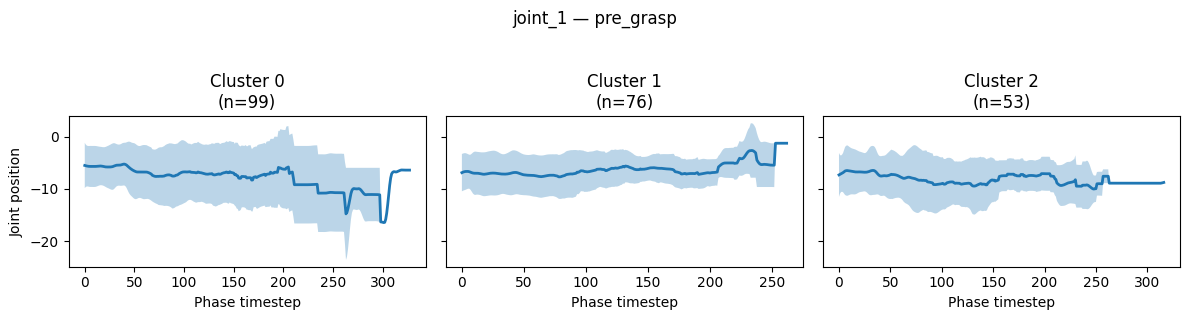

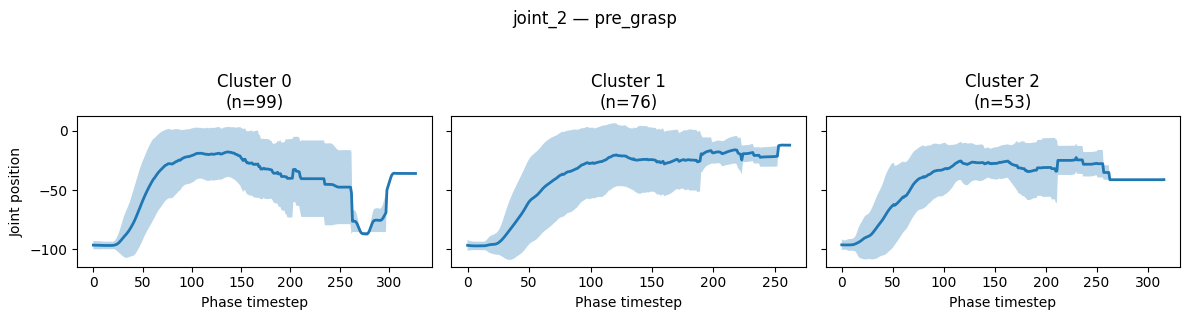

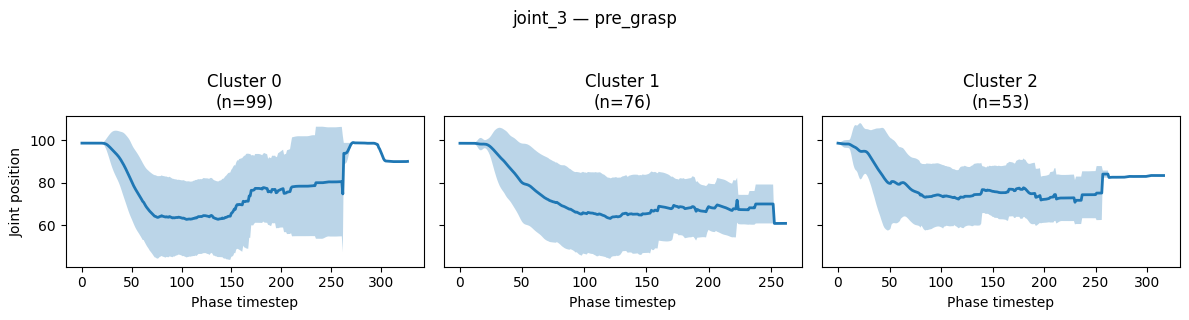

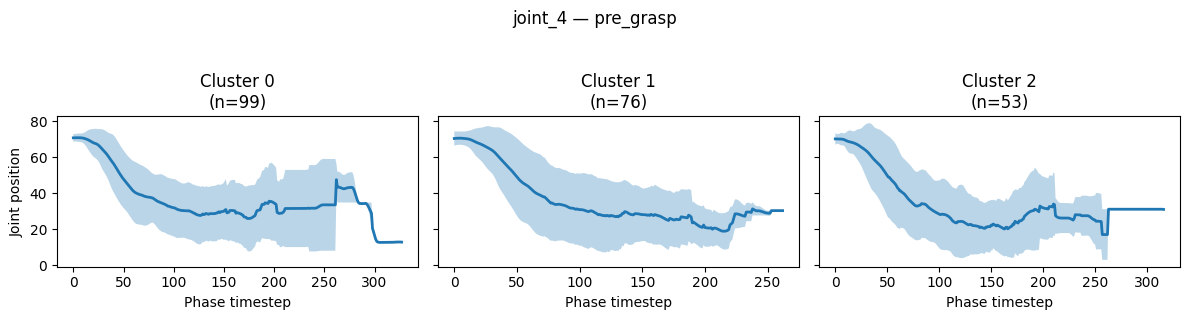

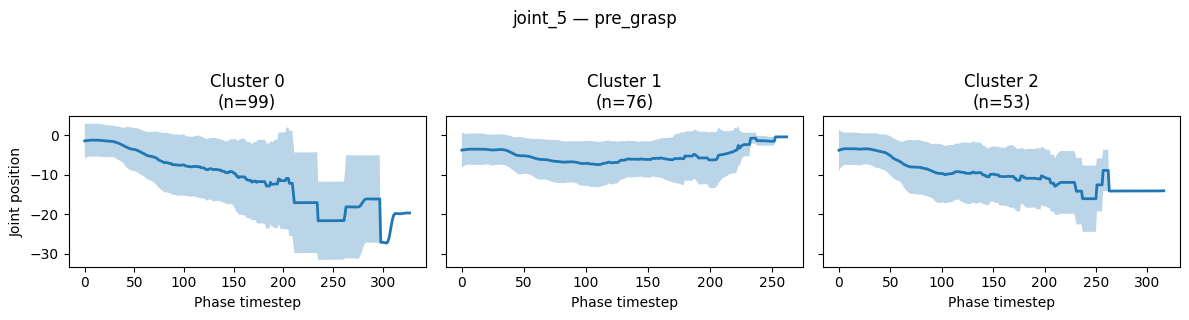

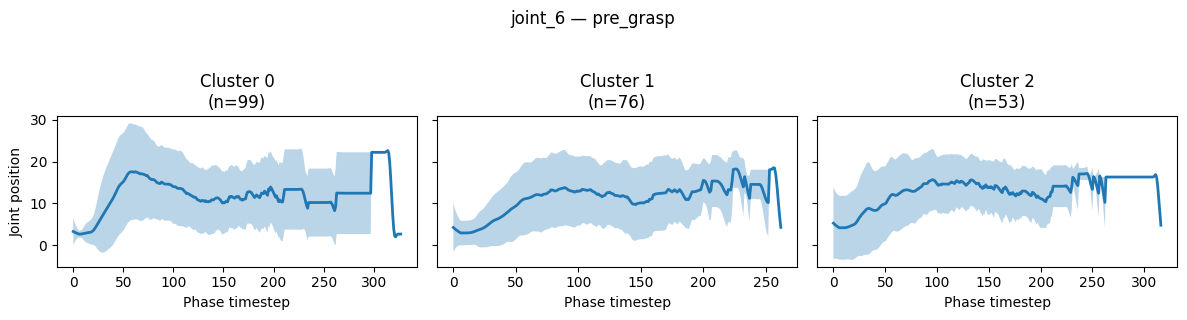

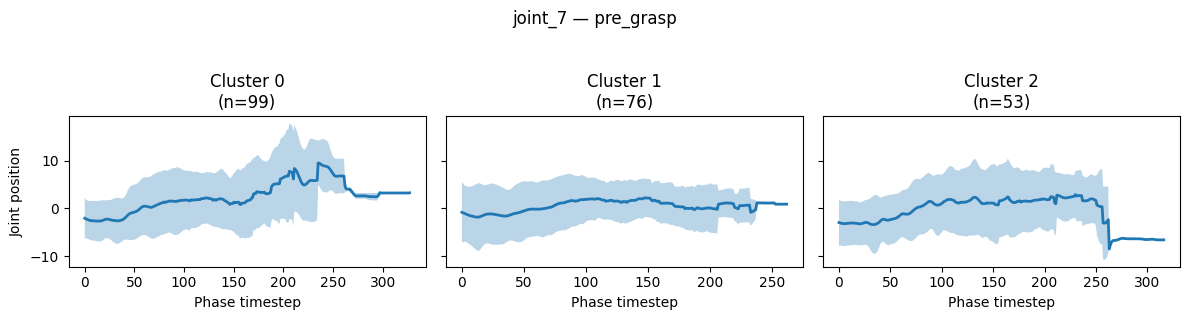

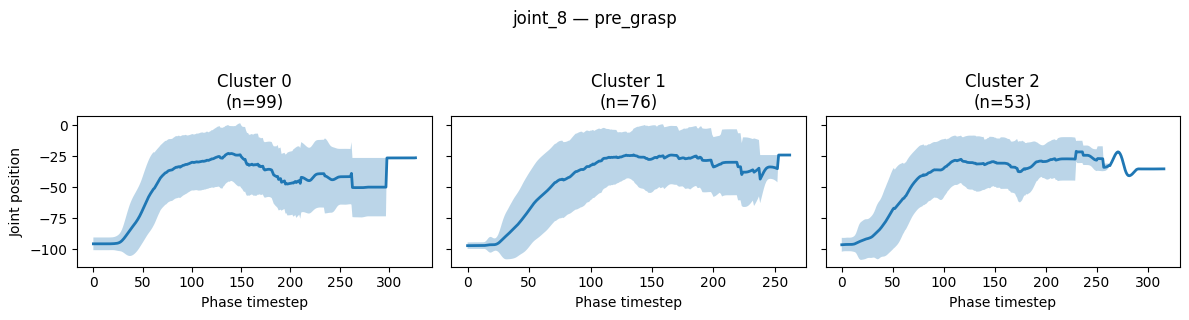

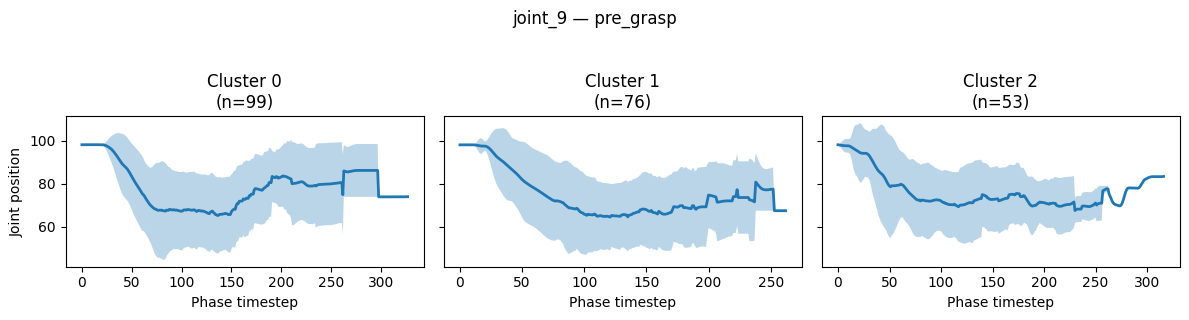

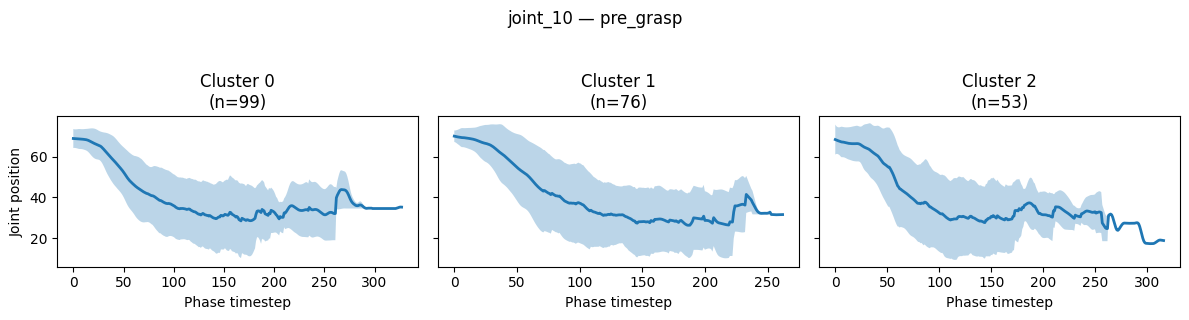

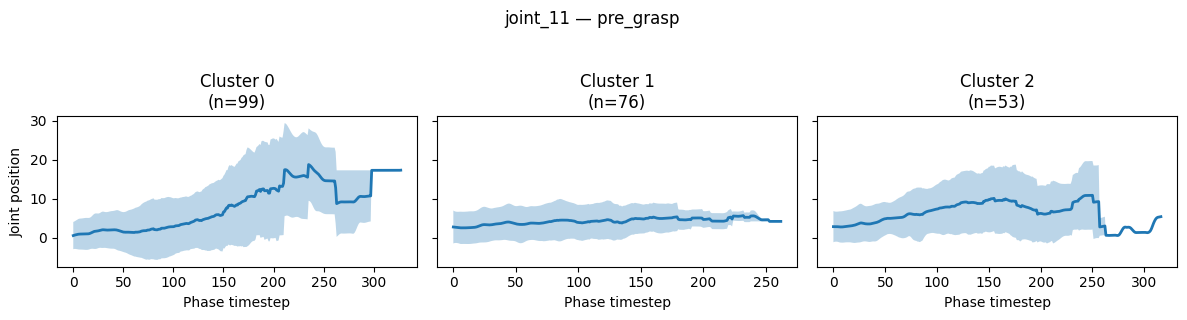

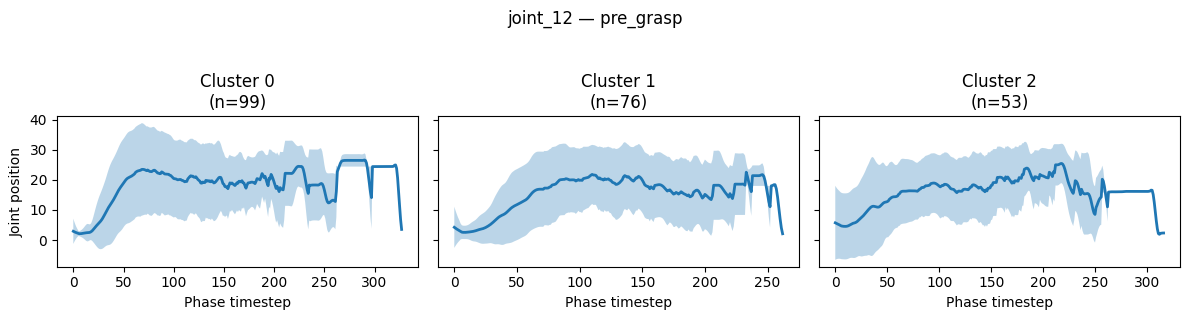

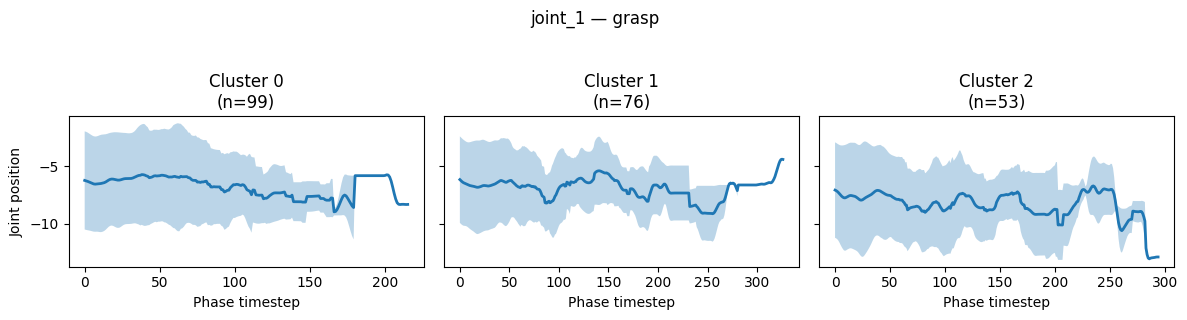

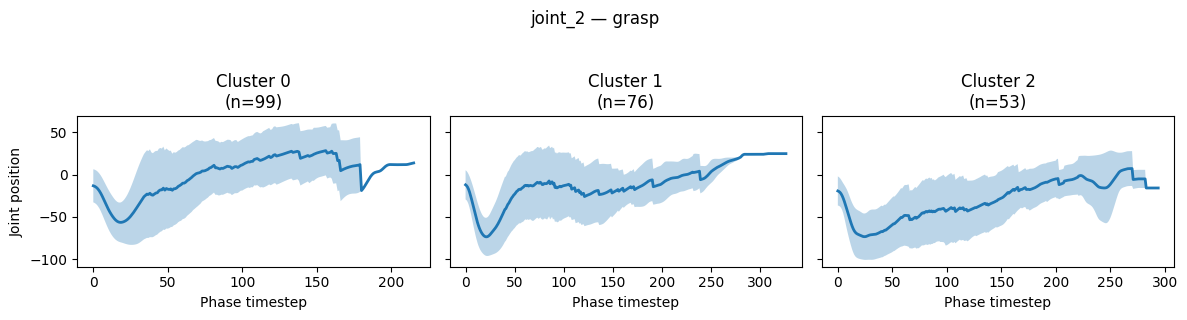

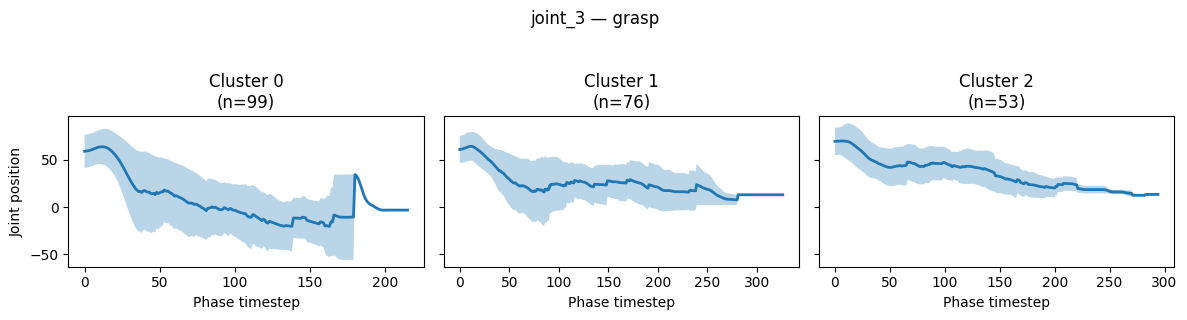

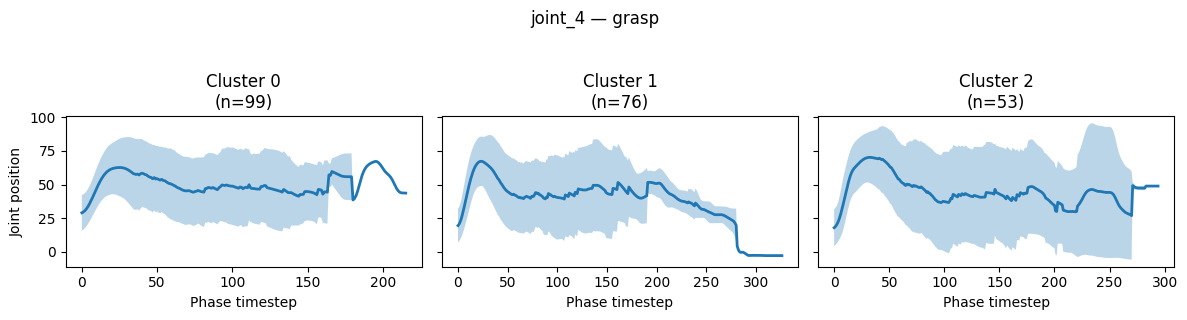

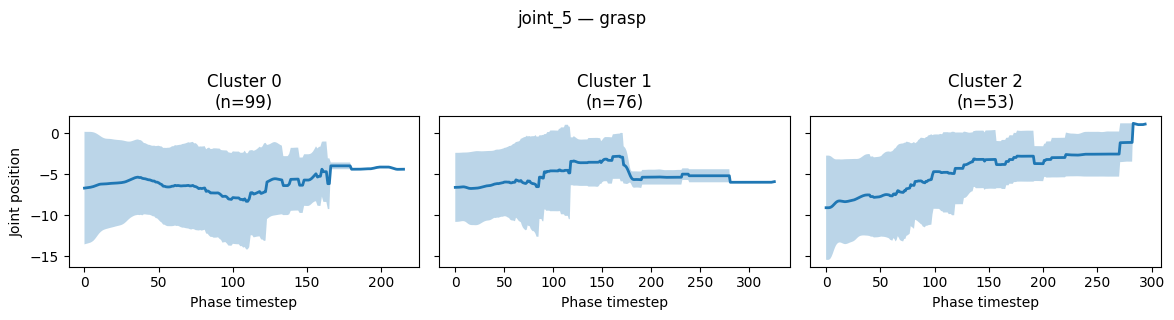

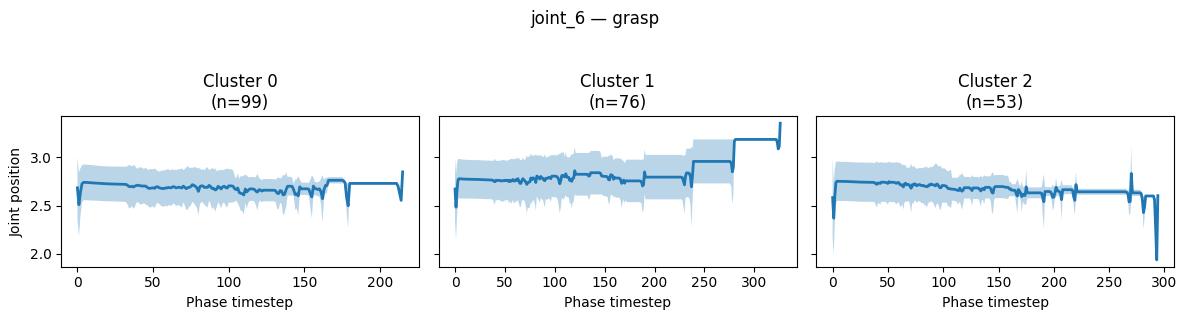

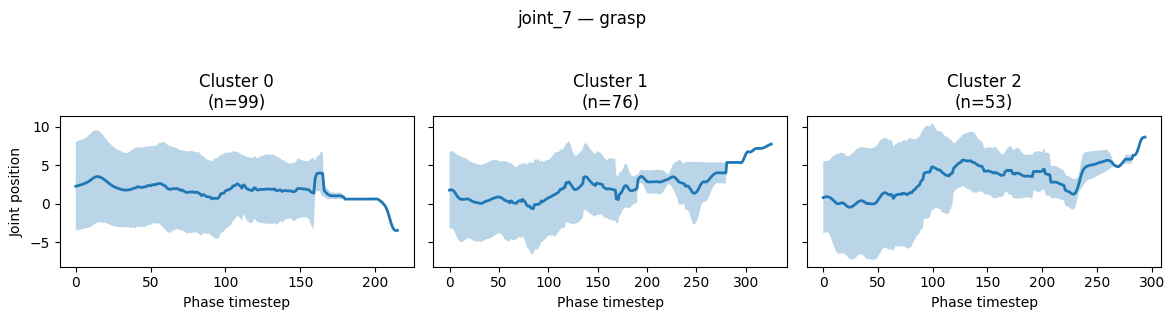

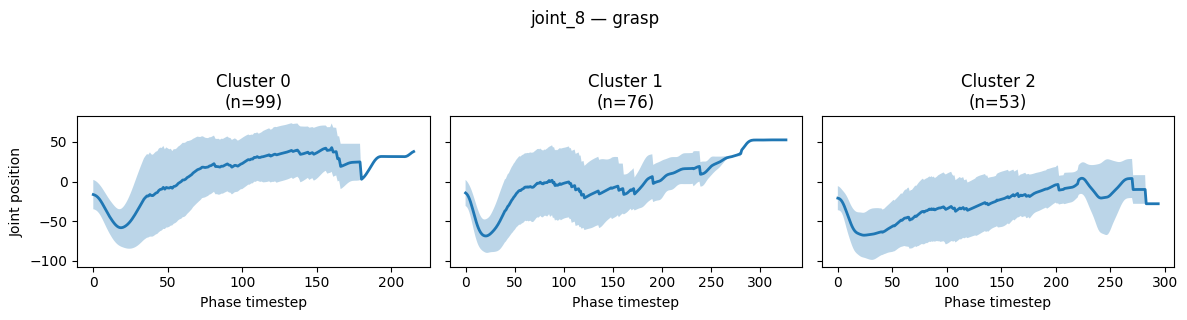

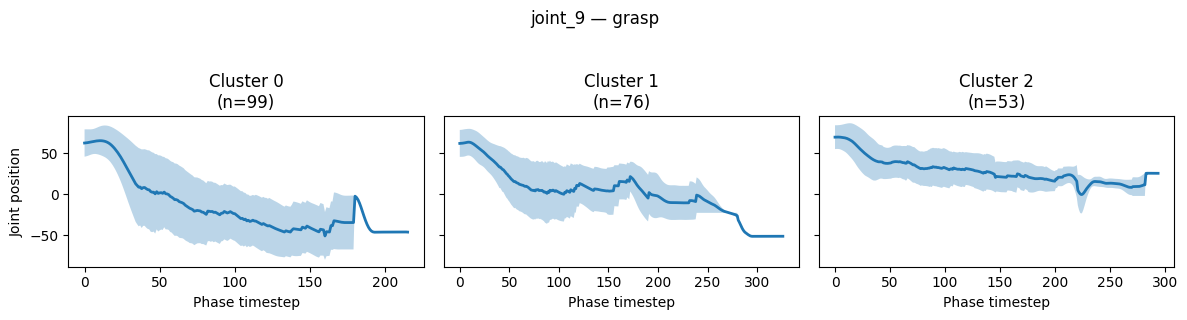

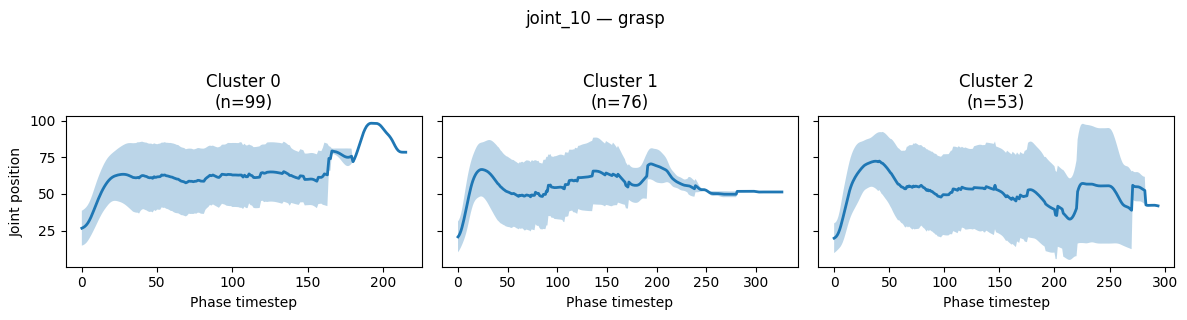

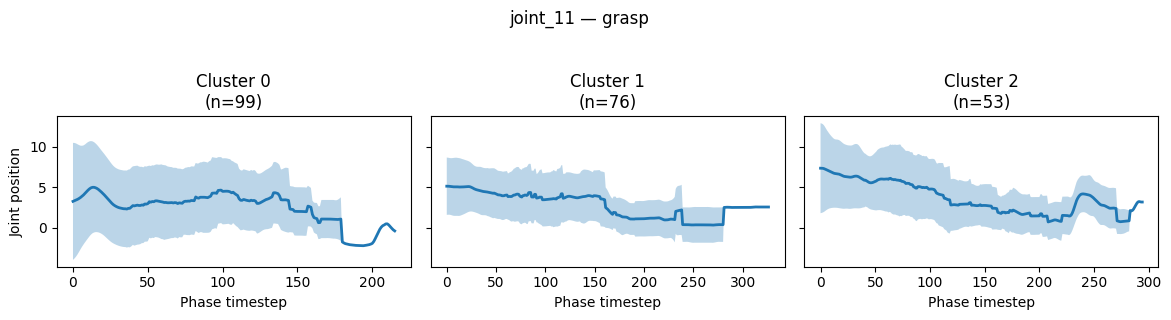

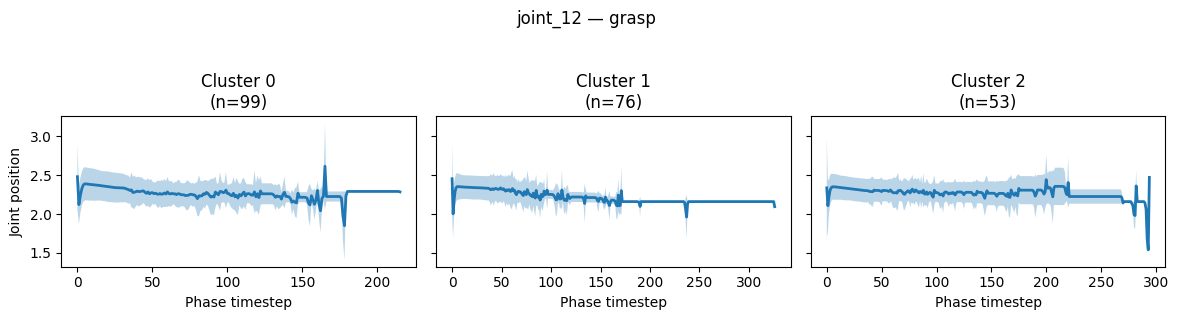

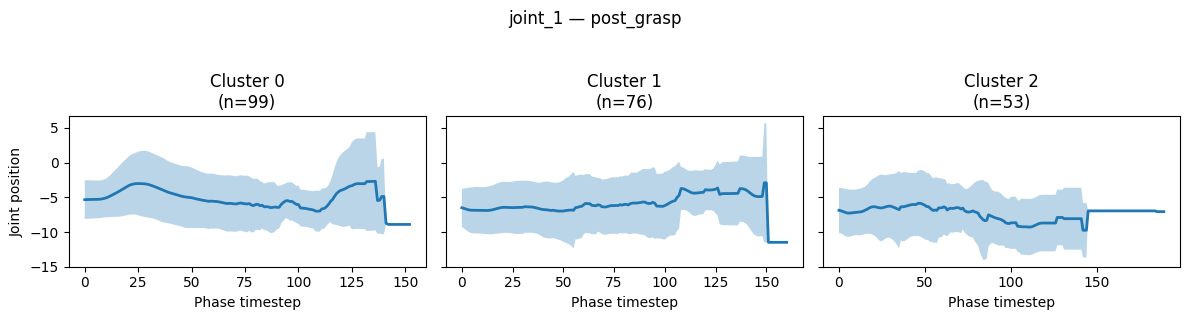

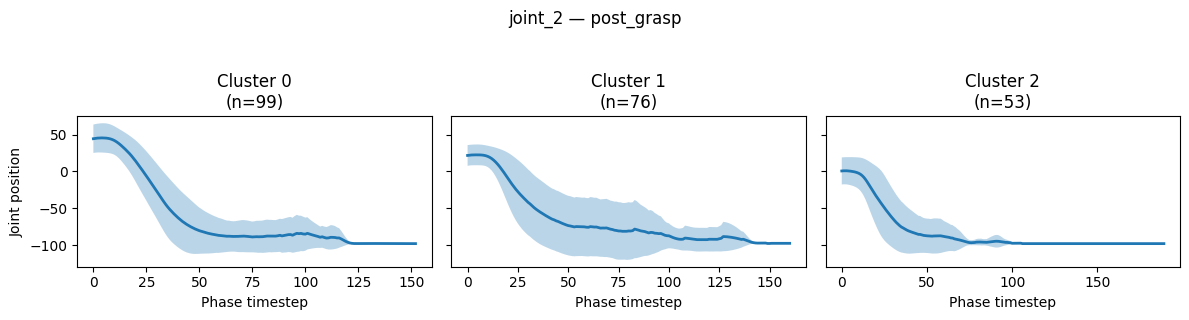

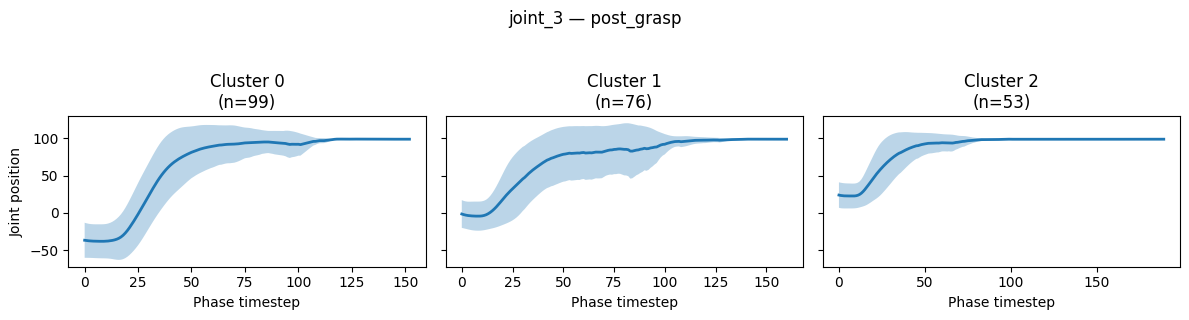

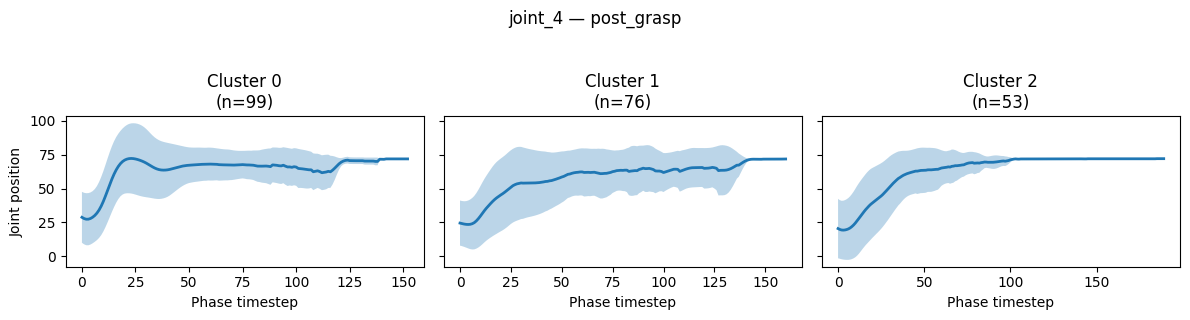

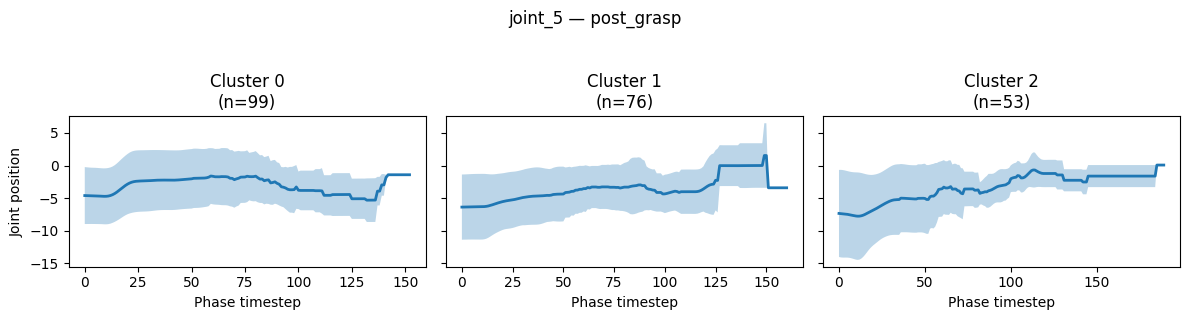

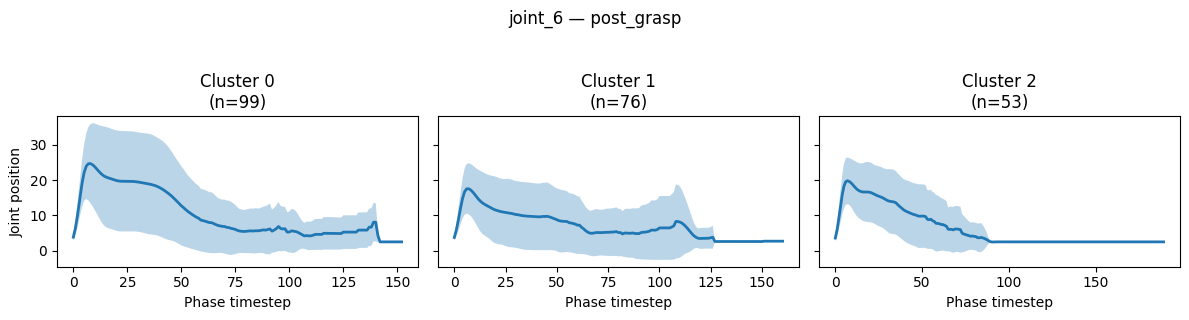

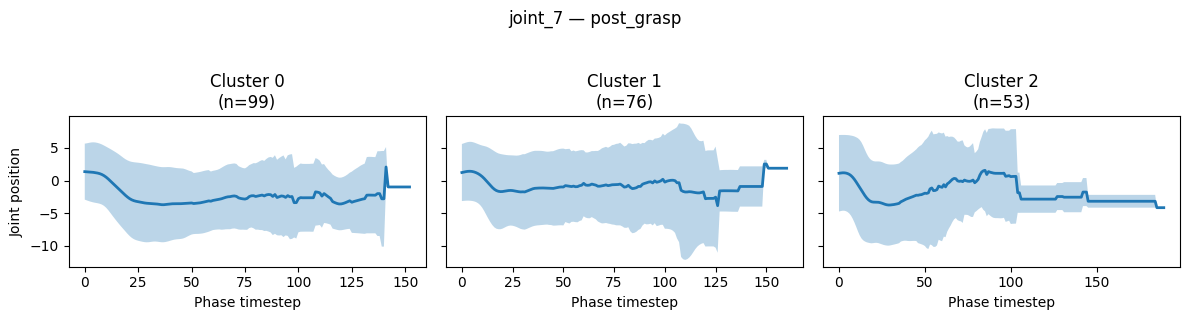

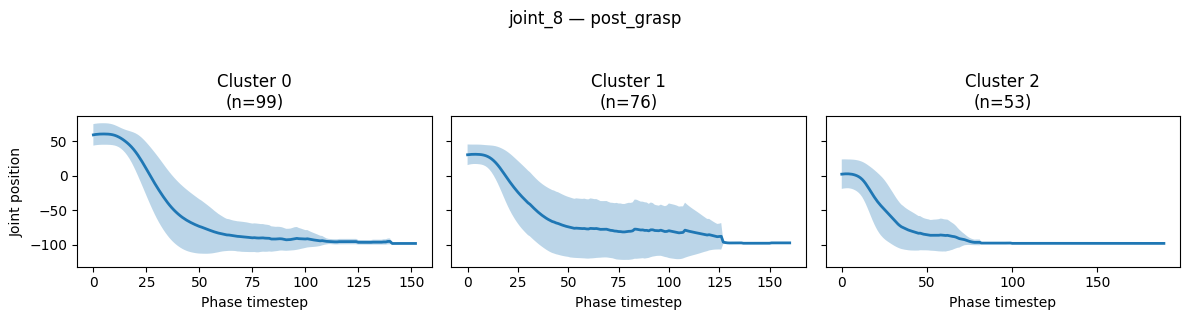

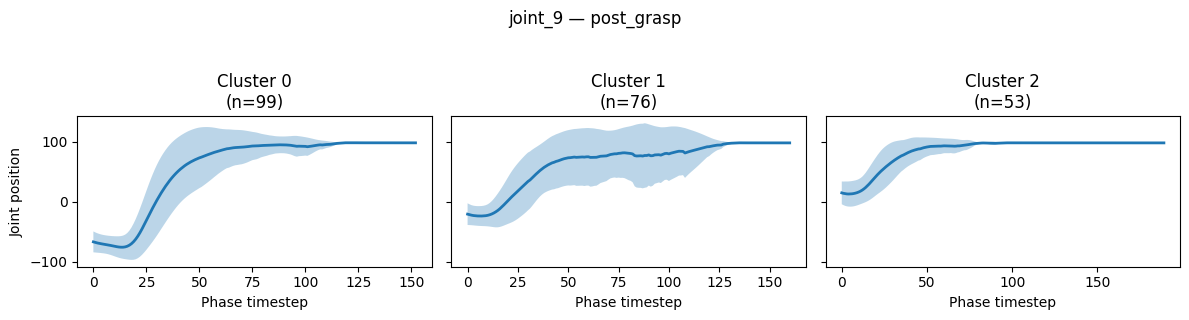

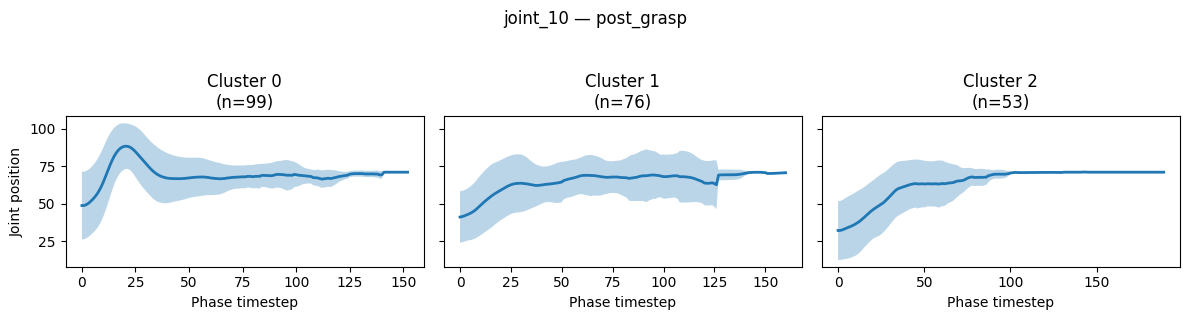

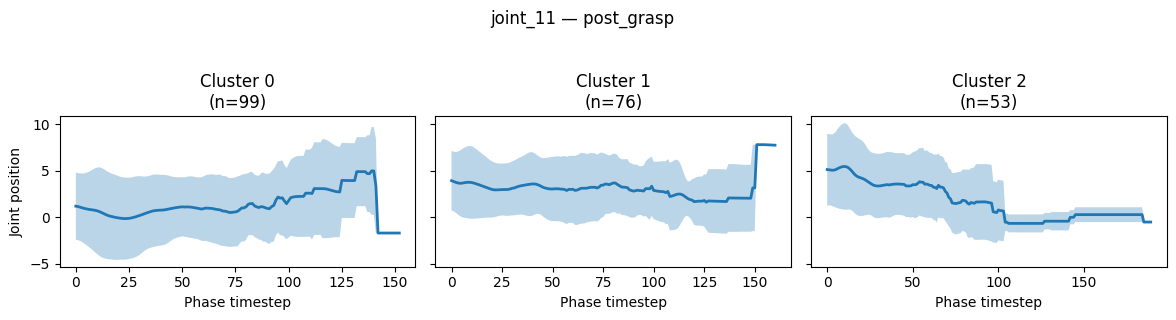

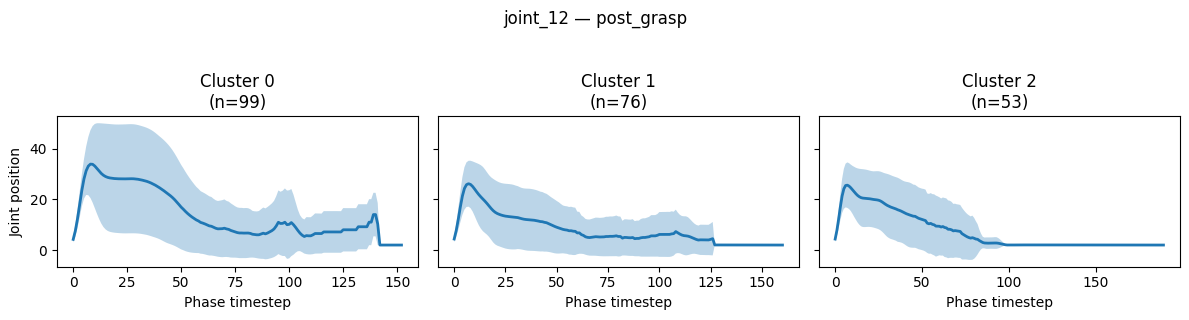

In [ ]:
def plot_joint_phase_by_cluster(
    episodes_df,
    joint,
    phase_name,
    cluster_col="cluster",
    phase_col="phase",
    min_len=5,
    show_individual=False
):
    clusters = sorted(episodes_df[cluster_col].unique())
    n_clusters = len(clusters)

    fig, axes = plt.subplots(
        1, n_clusters,
        figsize=(4 * n_clusters, 3),
        sharey=True
    )

    if n_clusters == 1:
        axes = [axes]

    for ax, cluster_id in zip(axes, clusters):
        cluster_eps = episodes_df[episodes_df[cluster_col] == cluster_id]

        sequences = []

        for _, row in cluster_eps.iterrows():
            mask = row[phase_col] == phase_name
            seq = row["states"][joint][mask]

            if len(seq) >= min_len:
                sequences.append(seq)

                if show_individual:
                    ax.plot(seq, alpha=0.2, linewidth=1)

        if len(sequences) == 0:
            ax.set_title(f"Cluster {cluster_id}\n(no data)")
            continue

        # pad to same length
        max_len = max(len(s) for s in sequences)
        padded = np.full((len(sequences), max_len), np.nan)

        for i, s in enumerate(sequences):
            padded[i, :len(s)] = s

        mean = np.nanmean(padded, axis=0)
        std = np.nanstd(padded, axis=0)

        t = np.arange(len(mean))

        ax.plot(t, mean, linewidth=2)
        ax.fill_between(t, mean - std, mean + std, alpha=0.3)

        ax.set_title(f"Cluster {cluster_id}\n(n={len(sequences)})")
        ax.set_xlabel("Phase timestep")

    axes[0].set_ylabel("Joint position")
    fig.suptitle(f"{joint} — {phase_name}", y=1.05)
    plt.tight_layout()
    plt.show()

for phase in phases:
    for joint in list(episodes_df.iloc[0]["states"].keys()):
        plot_joint_phase_by_cluster(
            episodes_df,
            joint,
            phase
        )

Seem to be getting discrete clusters based on movement over time (motion patterns) and duration. Nice :)

1. Phase segmentation method
2. DTW alignment justification
3. Episode-level clustering
4. Phase-wise cluster comparison
5. Mean ± std visualisations per cluster
6. Interpretation (only after structure is found)